In [24]:
import ase
import ase.io as aio
import numpy as np
import pandas as pd
from ase.optimize import LBFGS
from mace.calculators import mace_off
from rdkit import Chem
from rdkit.Chem.rdDistGeom import EmbedMolecule, ETKDGv3

In [6]:
df = pd.read_csv("./fda_approved_drugs.txt", sep="\t")
df = df.query("~smiles.isna()")
mols = [Chem.MolFromSmiles(smi) for smi in df.smiles]

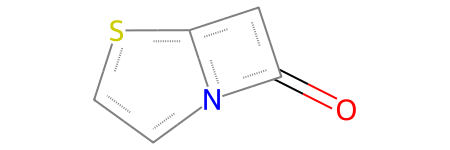

In [7]:
patt = Chem.MolFromSmarts("O=C1CC2N1CC[S;X2]2")
patt

In [10]:
penicillin_analogues = [mol for mol in mols if mol.HasSubstructMatch(patt)]

In [19]:
atoms = []
core_ids = []
for mol in penicillin_analogues:
    m = Chem.AddHs(mol)
    matches = m.GetSubstructMatches(patt)
    embed_settings = ETKDGv3()
    EmbedMolecule(m, embed_settings)
    assert m.GetNumConformers() != 0
    pos = m.GetConformer().GetPositions()
    symbols = [a.GetSymbol() for a in m.GetAtoms()]
    atoms.append(ase.Atoms(symbols, positions=pos))
    core_ids.append(matches[0])

In [21]:
calc = mace_off("medium", device="cuda", dtype="float32")

Using MACE-OFF23 MODEL for MACECalculator with /home/rokas/.cache/mace/MACE-OFF23_medium.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/home/rokas/miniconda3/envs/genesis/lib/python3.12/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_loc

In [23]:
for a in atoms:
    a.calc = calc
    opt = LBFGS(a)
    opt.run(fmax=1e-1)
    a.calc = None

       Step     Time          Energy          fmax
LBFGS:    0 22:34:40   -37396.872587        0.000904
       Step     Time          Energy          fmax
LBFGS:    0 22:34:40   -42466.284247        0.304366
LBFGS:    1 22:34:40   -42466.290816        0.362971
LBFGS:    2 22:34:40   -42466.300274        0.204065
LBFGS:    3 22:34:41   -42466.304850        0.201523
LBFGS:    4 22:34:41   -42466.312382        0.194632
LBFGS:    5 22:34:41   -42466.320361        0.168784
LBFGS:    6 22:34:41   -42466.326206        0.176232
LBFGS:    7 22:34:41   -42466.333292        0.206828
LBFGS:    8 22:34:41   -42466.340992        0.214106
LBFGS:    9 22:34:41   -42466.349181        0.185147
LBFGS:   10 22:34:41   -42466.356079        0.179857
LBFGS:   11 22:34:41   -42466.361168        0.160580
LBFGS:   12 22:34:42   -42466.365983        0.154821
LBFGS:   13 22:34:42   -42466.371524        0.153538
LBFGS:   14 22:34:42   -42466.378666        0.259835
LBFGS:   15 22:34:42   -42466.387544        0.3536

In [25]:
core_ids_np = np.array(core_ids)
core_ids_np

array([[ 4,  3,  2, 14,  5,  6, 10, 13],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [15, 14, 13, 25, 16, 17, 21, 24],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 4,  3,  2, 22,  5,  6, 18, 21],
       [ 8,  7,  9,  0,  6,  5,  2,  1]])

In [ ]:
aio.write("penicillin_analogues.xyz", atoms)
np.save("core_ids.npy", core_ids_np)